## Prediction of user Knowledge

**Introduction**

The data set records the standardized results of study time, repetition, exam performance for the goal subject as well as non-goal but related subjects. It has a target value of user knowledge classified as very low, low, middle, or high. 

Research question: How can and exam performance on the goal object as well as exam performance on subjects related to goal object predict user knowledge?

The data set we will be using is taken from the UCI Machine learning repository titled, “User Knowledge Modeling Data Set”. The training data set contains 258 observations. There are 6 variables measured: STG (The degree of study time for goal object materials), SCG (The degree of repetition number of user for goal object materials), STR (The degree of study time of user for related objects with goal object), LPR (The exam performance of user for related objects with goal object), and PEG (The exam performance of user for goal object). Each of the variables are standardized. (Kahraman et Al.). There is research done on how general knowledge can be used to predict test scores (Hartwig et Al.), so in contrast, this data utilizes hard data such as test scores and studying time as the variables to something more abstract such as knowledge. 

In [1]:
#Required libraries 
import altair as alt
import pandas as pd 
import numpy as np
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

## Methods

Firstly we wil create scatterplots with PEG (exam performance on goal object) on the y-axis and each of the other 4 variables with the shape and color aissgned by the UNS. Following this we identified that then We will use LPR and PEG to predict. As these two variables are both focused on exam performance, they provide a sense of coherence to the analysis. We will use the technique of classification on the training set to predict whether a new observation would be classified into one of the four categories of the knowledge level of the user.

We will plot the dataset as a scatterplot, with LPR on the x-axis, PEG on the y-axis and we will use color and shape to distinct different categories of UNS. 

### Loads data from the original source on the web & cleans 

In [2]:
#importing the data set
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls"

user_knowledge_data = pd.read_excel(url, sheet_name = 1).drop(columns = ["Unnamed: 6", "Unnamed: 7", "Attribute Information:"])
user_knowledge_data

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low
...,...,...,...,...,...,...
253,0.61,0.78,0.69,0.92,0.58,High
254,0.78,0.61,0.71,0.19,0.60,Middle
255,0.54,0.82,0.71,0.29,0.77,High
256,0.50,0.75,0.81,0.61,0.26,Middle


### Summary of the data

In [3]:
user_knowledge_data.agg(["min", "max"])

,STG,SCG,STR,LPR,PEG,UNS
min,0.00,0.0,0.00,0.00,0.00,High
max,0.99,0.9,0.95,0.99,0.93,very_low


In [4]:
#UNS_data = user_knowledge_data[[" UNS"]]
data= user_knowledge_data.assign(count = 0)
data = data.iloc[:,5:7].groupby(" UNS").count().reset_index()
data

,UNS,count
0,High,63
1,Low,83
2,Middle,88
3,very_low,24


### Visualization of the dataset

In [5]:
user_chart = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("STG", title = "The degree of study time for goal object materials (Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart        

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [6]:
user_chart2 = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("SCG", title = "The degree of repetition number of user for goal object materials (Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart2  

alt.Chart(...)

In [7]:
user_chart3 = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("STR", title = "The degree of study time of user for related objects with goal object(Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart3

alt.Chart(...)

In [8]:
user_chart4 = (
    alt.Chart(user_knowledge_data)
    .mark_point()
    .encode(
        x = alt.X("LPR", title = "The exam performance of user for related objects with goal object(Standardized)"),
        y = alt.Y("PEG", title = "Exam performance for goal object (standardized)"),
        color = " UNS",
        shape = " UNS"
)).properties(width=400, height=400)
user_chart4  

alt.Chart(...)

### Data Analysis
#### Split training set and testing set

In [9]:
# usr_training, usr_test = train_test_split(user_knowledge_data,test_size=0.25,random_state=123)
# print(usr_training.head())
# print(usr_test.head())

## change it here so that we use "user_knowledge_data" as the training and 
## upload the testing set from the web because it came with both already split

usr_training = pd.read_excel(url, sheet_name = 1).drop(columns = ["Unnamed: 6", "Unnamed: 7", "Attribute Information:"])
usr_test = pd.read_excel(url, sheet_name = 2).drop(columns = ["Unnamed: 6", "Unnamed: 7", "Attribute Information:"])

#### Assign predictors and targets

In [10]:
X_train = pd.DataFrame(usr_training.loc[:,["LPR","PEG"]])
y_train = usr_training[" UNS"]
X_test = pd.DataFrame(usr_test.loc[:,["LPR","PEG"]])
y_test = usr_test[" UNS"]


#### Pick K-value using GridSearch

In [11]:
'''
Create prepocessor, pipeline, and knn
'''
usr_data_prepocessor = make_column_transformer((StandardScaler(),["LPR","PEG"]),)
knn = KNeighborsClassifier()
usr_data_pipe = make_pipeline(usr_data_prepocessor,knn)


param_grid = {"kneighborsclassifier__n_neighbors": range(2, 50, 1),}

In [12]:
'''
Create grid search
'''
usr_data_tune_grid = GridSearchCV(
    estimator=usr_data_pipe, param_grid=param_grid, cv=5
)
usr_data_tune_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LPR',
                                                                          'PEG'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(2, 50)})

In [13]:
'''
Fit the model to the data
'''
usr_data_model_grid = usr_data_tune_grid.fit(X_train,y_train)
accruacies_grid = pd.DataFrame(usr_data_model_grid.cv_results_)
accruacies_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.028715,0.012652,0.022476,0.001989,2,{'kneighborsclassifier__n_neighbors': 2},0.961538,0.923077,0.903846,1.0,0.921569,0.942006,0.034575,9
1,0.022033,0.002867,0.024952,0.007284,3,{'kneighborsclassifier__n_neighbors': 3},0.980769,0.961538,0.923077,1.0,1.000000,0.973077,0.028782,1
2,0.018676,0.001801,0.021950,0.001609,4,{'kneighborsclassifier__n_neighbors': 4},0.942308,0.961538,0.903846,1.0,0.941176,0.949774,0.031305,6
3,0.020111,0.004278,0.024223,0.007269,5,{'kneighborsclassifier__n_neighbors': 5},0.942308,0.961538,0.923077,1.0,0.960784,0.957541,0.025492,2
4,0.025541,0.015080,0.022643,0.012752,6,{'kneighborsclassifier__n_neighbors': 6},0.942308,0.961538,0.903846,1.0,0.960784,0.953695,0.031211,3


In [14]:
'''
Plot the accuracy against k to find the ideal k value
'''
accuracy_versus_k_grid = (
    alt.Chart(accruacies_grid, title="Grid Search")
    .mark_line(point=True)
    .encode(
        x=alt.X(
            "param_kneighborsclassifier__n_neighbors",
            title="Neighbors",
            scale=alt.Scale(zero=False),
        ),
        y=alt.Y(
            "mean_test_score", 
            title="Mean Test Score", 
            scale=alt.Scale(zero=False)
        ),
    )
    .configure_axis(labelFontSize=10, titleFontSize=15)
    .properties(width=800, height=600)
)
accuracy_versus_k_grid

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

It is clear from the above plot that when $k=3$ or when $k=5$, the mean test score is the highest. We will test the accuacy of both to determine which k value to choose. $\\$
(Test the model with GridSearchRange from $2$ to $100$, and the mean test score continues to drop after $k=50$, for better view of the plot, just pick the range from $2$ to $50$)

#### Set the model for K=5

In [15]:
'''
create knn, pipeline
'''
knn_spec = KNeighborsClassifier(n_neighbors=5)
usr_data_fit = make_pipeline(usr_data_prepocessor,knn_spec).fit(X_train,y_train)
usr_data_fit

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LPR', 'PEG'])])),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [16]:
'''
user the model to predict test data and calculate the accuracy of the model
'''
usr_data_test_predictions = usr_test.assign(predictions=usr_data_fit.predict(X_test))

X_test_pred = usr_data_test_predictions[["LPR","PEG"]]
y_test_pred = usr_data_test_predictions[" UNS"]
usr_data_pred_accuracy = usr_data_fit.score(X_test_pred,y_test_pred)
usr_data_pred_accuracy


0.8068965517241379

#### Set model for K=3

In [17]:
knn_spec_3 = KNeighborsClassifier(n_neighbors=3)
usr_data_fit_3 = make_pipeline(usr_data_prepocessor,knn_spec_3).fit(X_train,y_train)
usr_data_fit_3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LPR', 'PEG'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [18]:
usr_data_test_predictions_3 = usr_test.assign(predictions=usr_data_fit_3.predict(X_test))

X_test_pred_3 = usr_data_test_predictions_3[["LPR","PEG"]]
y_test_pred_3 = usr_data_test_predictions_3[" UNS"]
usr_data_pred_accuracy_3 = usr_data_fit_3.score(X_test_pred_3,y_test_pred_3)
usr_data_pred_accuracy_3

0.7862068965517242

Since the accuracy score of $K=5$ is slightly higher than $K=3$, so we will use $K=5$ 

#### Cross-Validation

In [19]:
'''
Check if the model is overfit
'''
np.random.seed(2020)
usr_data_vfold_score = cross_validate(estimator=usr_data_fit,X=X_train,y=y_train,return_train_score=True,)
pd.DataFrame(usr_data_vfold_score)

,fit_time,score_time,test_score,train_score
0,0.008176,0.010219,0.942308,0.961165
1,0.006568,0.007499,0.961538,0.970874
2,0.006749,0.007397,0.923077,0.980583
3,0.021254,0.023286,1.000000,0.971014
4,0.020772,0.022657,0.960784,0.956522


#### Visualization of the model

In [20]:
usr_data_mat = confusion_matrix(
    usr_data_test_predictions[" UNS"],  # true labels
    usr_data_test_predictions["predictions"],  # predicted labels
    labels=usr_data_fit.classes_, # specify the label for each class
)

usr_data_mat

array([[39,  0,  0,  0],
       [ 0, 45,  1,  0],
       [ 0,  1, 33,  0],
       [ 0,  0,  0,  0]])

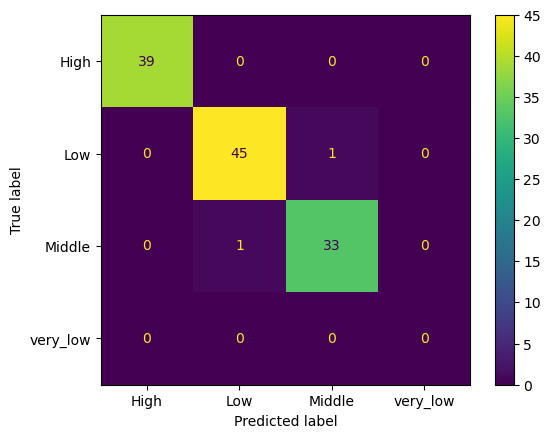

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(
    confusion_matrix=usr_data_mat, display_labels=usr_data_fit.classes_
)
disp.plot()

In [22]:
import numpy as np

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid = np.linspace(
    user_knowledge_data["LPR"].min(), user_knowledge_data["LPR"].max(), 50
)
smo_grid = np.linspace(
    user_knowledge_data["PEG"].min(), user_knowledge_data["PEG"].max(), 50
)
asgrid = np.array(np.meshgrid(are_grid, smo_grid)).reshape(2, -1).T
asgrid = pd.DataFrame(asgrid, columns=["LPR", "PEG"])

# use the fit workflow to make predictions at the grid points
knnPredGrid = usr_data_fit.predict(asgrid)

# bind the predictions as a new column with the grid points
prediction_table = asgrid.copy()
prediction_table[" UNS"] = knnPredGrid

# plot:
# 1. the colored scatter of the original data
unscaled_plot = (
    alt.Chart(
        user_knowledge_data,
    )
    .mark_point(opacity=0.6, filled=True, size=40)
    .encode(
        x=alt.X(
            "LPR",
            title="LPR",
            scale=alt.Scale(
                domain=(user_knowledge_data["LPR"].min(), user_knowledge_data["LPR"].max())
            ),
        ),
        y=alt.Y(
            "PEG",
            title="PEG",
            scale=alt.Scale(
                domain=(
                    user_knowledge_data["PEG"].min(),
                    user_knowledge_data["PEG"].max(),
                )
            ),
        ),
        color=alt.Color(" UNS", title="UNS"),
    )
)

# 2. the faded colored scatter for the grid points
prediction_plot = (
    alt.Chart(prediction_table)
    .mark_point(opacity=0.05, filled=True, size=300)
    .encode(
        x=alt.X("LPR"),
        y=alt.Y("PEG"),
        color=alt.Color(" UNS", title="UNS"),
    )
)
unscaled_plot + prediction_plot

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

**Expected Outcomes and Significance**


We expect that by using the two variables for the exam performance of user for related objects with goal object (LPR) and the exam performance of users (PEG) we would be able to predict the possible knowledge level of the user (UNS). Since there is a clear distinction between the levels of knowledge in the scatter plot provided we believe using K nearest neighbours would provide an accurate prediction for the users knowledge level.

Our findings could assess common methods for classifying students in settings where knowledge is heavily based on test scores such as in high school and in university. We can find if different variables such as test scores on the target object as well as study time with goal object accurately predict knowledge and how that can be translated to the system that schools currently use and if they are reliable and viable. 

One straightforward question may be “Are there any variables that could improve the accuracy of the prediction?”, as we are now using only two out of five variables to predict. Further down this path, another example of a potential future question could be, “Are Degree of Study time(STR) and Exam performance of users (PEG) the most two determinant variables among the five input variables for deciding a user’s knowledge level?” In an attempt to find the most accurate prediction, one may proceed by choosing variables to build the model and compare it with this one.



**References**

1) Hartwig, Marissa K., et al. “General Knowledge Monitoring as a Predictor of in-Class Exam Performance.” British Journal of Educational Psychology, vol. 82, no. 3, 2011, pp. 456–468., https://doi.org/10.1111/j.2044-8279.2011.02038.x. 

2) H. T. Kahraman, Sagiroglu, S., Colak, I., Developing intuitive knowledge classifier and modeling of users' domain dependent data in web, Knowledge Based Systems, vol. 37, pp. 283-295, 2013.
